In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

data = pd.get_dummies(data, columns=["Churn"], drop_first=True)

data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])


num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=5,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

pipeline = Pipeline([("droper", DropTransformer(threshold = 0.95))])

data_prepared = pipeline.fit_transform(new_data)

X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25,
                                                  random_state=44, stratify=data_labels)

It works!


#### wybranie najlepszych modeli

In [3]:
log_clf = LogisticRegression(C=0.5, solver="liblinear", class_weight="balanced", random_state=44)
rnd_clf = RandomForestClassifier(max_depth=7, max_features="auto", min_samples_leaf=10, class_weight="balanced", random_state=44)
svm_clf = SVC(kernel="rbf", C=1, gamma="auto", class_weight="balanced", random_state=44, probability=True)
knn_clf = KNeighborsClassifier(n_neighbors = 41, leaf_size = 10, p = 1, metric = "euclidean", weights = "uniform")

#### wyuczenie modelu votingclassifier

In [57]:
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("knc", knn_clf)],
    voting="hard")

In [58]:
print("   model   ", "   accuracy   ", "   recall   ")
for clf in (log_clf, rnd_clf, svm_clf, knn_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred),3), round(recall_score(y_val, y_pred), 3))

   model       accuracy       recall   
LogisticRegression 0.743 0.804
RandomForestClassifier 0.758 0.785
SVC 0.719 0.815
KNeighborsClassifier 0.795 0.594
VotingClassifier 0.763 0.753


#### bez knn

In [59]:
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard")

print("   model   ", "   accuracy   ", "   recall   ")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred),3), round(recall_score(y_val, y_pred), 3))

   model       accuracy       recall   
LogisticRegression 0.743 0.804
RandomForestClassifier 0.758 0.785
SVC 0.719 0.815
VotingClassifier 0.743 0.806


#### kalibracja thresholdu (voting soft)

In [34]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [61]:
voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="soft")

print("   model   ", "   accuracy   ", "   recall   ")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred),3), round(recall_score(y_val, y_pred), 3))

   model       accuracy       recall   
LogisticRegression 0.743 0.804
RandomForestClassifier 0.758 0.785
SVC 0.719 0.815
VotingClassifier 0.762 0.747


Best Threshold=0.443891, G-Mean=0.768


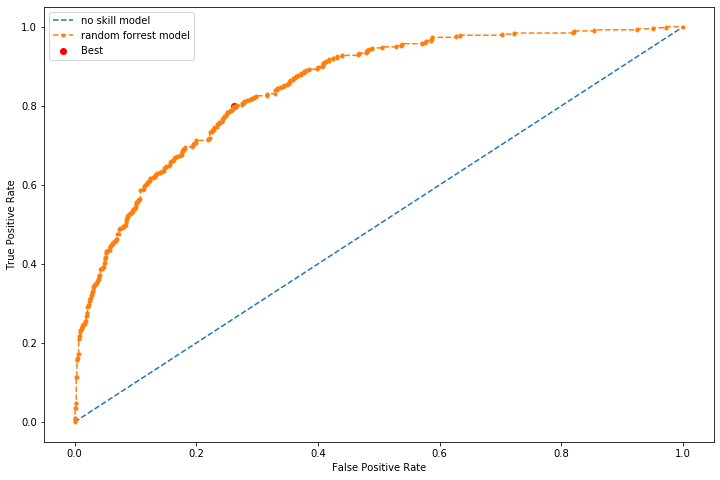

In [62]:
fpr, tpr, thresholds = roc_curve(y_val, voting_clf.predict_proba(X_val)[:,1])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure(figsize = (12, 8))
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [63]:
print(classification_report(y_val, to_labels(voting_clf.predict_proba(X_val)[:,1], thresholds[ix])))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.80      0.63       372

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.77      1407

